In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from tsfresh import extract_features
import pycatch22 as catch22

In [17]:
def normalize_array(arr: np.ndarray) -> np.ndarray:
    """
    Normalize a single array to the range [0, 1].

    Args:
        arr (np.ndarray): The input array to normalize.

    Returns:
        np.ndarray: The normalized array.
    """
    arr_min = arr.min()
    arr_max = arr.max()
    if arr_max - arr_min == 0:
        # Avoid division by zero if all values in the array are the same
        return np.zeros_like(arr)
    
    return (arr - arr_min) / (arr_max - arr_min)

In [8]:
def get_arrays(path, metric, loss, k):    
    df = pd.read_csv(path)

    filtered = df[df["epoch"] == 99]
    
    lowest_mae_models = filtered.nsmallest(k, metric)["model_id"].tolist()
    highest_mae_models = filtered.nlargest(k, metric)["model_id"].tolist()

    l = df[df["model_id"].isin(lowest_mae_models)]
    h = df[df["model_id"].isin(highest_mae_models)]

    print("Selected low metrics")
    print(l[l["epoch"] == 99][metric])
    print("Selected high metrics")
    print(h[h["epoch"] == 99][metric])
    print("Min and max")
    print(filtered[metric].min(), filtered[metric].max())

    nlf = l.groupby("model_id")[loss].apply(list).tolist()
    nl = np.apply_along_axis(normalize_array, axis=1, arr=nlf)

    nhf = h.groupby("model_id")[loss].apply(list).tolist()
    nh = np.apply_along_axis(normalize_array, axis=1, arr=nhf)

    return nl, nh

In [9]:
def plot_subplots_with_combined_range(red1, blue1, red2, blue2, red3, blue3, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    datasets = [(red1, blue1), (red2, blue2), (red3, blue3)]
    titles = ["Dataset 1", "Dataset 2", "Dataset 3"]
    
    for i, (red, blue) in enumerate(datasets):
        ax = axes[i]

        # Compute dynamic min and max for red dataset
        red_min_dynamic = np.minimum.accumulate(red, axis=0)
        red_max_dynamic = np.maximum.accumulate(red, axis=0)
        red_mean = np.mean(red, axis=0)

        # Compute dynamic min and max for blue dataset
        blue_min_dynamic = np.minimum.accumulate(blue, axis=0)
        blue_max_dynamic = np.maximum.accumulate(blue, axis=0)
        blue_mean = np.mean(blue, axis=0)

        # Plot red range with transparency
        ax.fill_between(range(red.shape[1]), red_min_dynamic[-1], red_max_dynamic[-1], color='red', alpha=0.3, label="Best Range")
        ax.plot(red_mean, color='red', label="Best Mean", linewidth=2)

        # Plot blue range with transparency
        ax.fill_between(range(blue.shape[1]), blue_min_dynamic[-1], blue_max_dynamic[-1], color='blue', alpha=0.3, label="Worst Range")
        ax.plot(blue_mean, color='blue', label="Worst Mean", linewidth=2)

        ax.set_title(titles[i])
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()


In [10]:
def plot_subplots_with_all_lines(red1, blue1, red2, blue2, red3, blue3, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    datasets = [(red1, blue1), (red2, blue2), (red3, blue3)]
    titles = ["Dataset 1", "Dataset 2", "Dataset 3"]
    
    for i, (red, blue) in enumerate(datasets):
        ax = axes[i]

        # Plot all red lines with transparency
        for r in red:
            ax.plot(r, color='red', alpha=0.2)  # Transparent lines

        # Plot all blue lines with transparency
        for b in blue:
            ax.plot(b, color='blue', alpha=0.2)  # Transparent lines

        # Compute and plot median (solid line)
        red_median = np.median(red, axis=0)
        blue_median = np.median(blue, axis=0)

        ax.plot(red_median, color='red', linewidth=2, label="Best Median")  # Solid line
        ax.plot(blue_median, color='blue', linewidth=2, label="Worst Median")  # Solid line

        ax.set_title(titles[i])
        ax.set_xlabel("X-axis")
        ax.set_ylabel("Y-axis")
        ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


In [11]:
import ast  # To safely parse lists
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
import shap

from sklearn.preprocessing import MinMaxScaler

# Data Preprocessing Function
def preprocess_data(path, metric):
    # Load CSV file
    df = pd.read_csv(path)
    
    print("Columns in CSV:", df.columns)  # Debugging step

    # Ensure 'epoch' column exists and filter for the last epoch
    if "epoch" in df.columns:
        df = df[df["epoch"] == 99]
    else:
        print("Error: 'epoch' column not found.")
        return None

    # Safe parsing of stringified lists
    def safe_parse_list(value):
        try:
            return ast.literal_eval(value) if isinstance(value, str) else []
        except:
            return []  # Return empty list if parsing fails

    # Manually create one-hot encoded columns for layers
    df["num_layers"] = df["layers"].apply(lambda x: len(safe_parse_list(x)))
    df["lstm"] = df["layers"].apply(lambda x: 1 if "lstm" in safe_parse_list(x) else 0)
    df["gru"] = df["layers"].apply(lambda x: 1 if "gru" in safe_parse_list(x) else 0)
    df["rnn"] = df["layers"].apply(lambda x: 1 if "rnn" in safe_parse_list(x) else 0)

    # Manually create one-hot encoded columns for activation functions
    df["sigmoid"] = df["activation"].apply(lambda x: 1 if "sigmoid" in safe_parse_list(x) else 0)
    df["relu"] = df["activation"].apply(lambda x: 1 if "relu" in safe_parse_list(x) else 0)
    df["tanh"] = df["activation"].apply(lambda x: 1 if "tanh" in safe_parse_list(x) else 0)

    # Manually create one-hot encoded columns for optimizers
    df["adam"] = df["optimizer"].apply(lambda x: 1 if x == "adam" else 0)
    df["sgd"] = df["optimizer"].apply(lambda x: 1 if x == "sgd" else 0)
    df["rmsprop"] = df["optimizer"].apply(lambda x: 1 if x == "rmsprop" else 0)

    # Convert 'neurons' to total sum
    df["neurons"] = df["neurons"].apply(lambda x: sum(safe_parse_list(x)) if isinstance(x, str) else x)

    # Convert 'dropout_rate' to first value (assuming it's consistent per layer)
    df["dropout_rate"] = df["dropout_rate"].apply(lambda x: safe_parse_list(x)[0] if safe_parse_list(x) else np.nan)

    # Select relevant columns for correlation
    if metric in df.columns:
        columns_of_interest = [metric, "batch_size", "neurons", "dropout_rate",
                               "lstm", "gru", "rnn",
                               "sigmoid", "relu", "tanh",
                               "adam", "sgd", "rmsprop", "num_layers", "learning_rate"]
    else:
        print(f"Error: Metric '{metric}' not found in CSV.")
        return None

    # Keep only numeric columns & drop NaNs
    df_selected = df[columns_of_interest].apply(pd.to_numeric, errors='coerce').dropna()

    # Debugging: Check if data is empty
    if df_selected.empty:
        print("Error: No valid data for preprocessing.")
        return None

    # Normalize data using MinMaxScaler (range [0, 1])
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)

    return df_normalized, df_selected


c:\Users\janav\AppData\Local\pypoetry\Cache\virtualenvs\green-ai-joMZuctV-py3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
def analyze_data(df_normalized, df_selected, metric=512, metric_n=512):
    # Separate features (X) and target (y)
    X = df_selected.drop(columns=[metric])
    y = df_selected[metric]  # Target metric
    
    # Mutual Information
    mi = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False).head(15)
    print("Mutual Information Scores:\n", mi_scores)
    
    # Random Forest Model
    model = RandomForestRegressor()
    model.fit(X, y)

    # SHAP analysis with additivity check disabled
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X, check_additivity=False)  # Disable additivity check
    shap.summary_plot(shap_values, X)
    
    # Compute correlation matrix (Spearman)
    correlation_matrix = df_normalized.corr(method='spearman')
    print("Correlation Matrix:\n", correlation_matrix)

    # Extract correlations for column 512 with all other columns
    column_512_corr = correlation_matrix[metric_n].drop(metric_n)  # Remove self-correlation

    # **Filter correlations to only keep values in the range [0.95 - 0.75]**
    filtered_corr = column_512_corr[abs(column_512_corr).between(0.65, 0.85)]

    # Get the top 15 most correlated features (if available)
    top_15_features = filtered_corr.abs().sort_values(ascending=False).head(15).index.tolist()

    # Ensure column 512 is included in the heatmap
    top_15_features.append(metric_n)  # Add column 512 back to the feature list

    # Filter the correlation matrix to only keep relevant features
    top_15_matrix = correlation_matrix.loc[top_15_features, top_15_features]

    # Plot heatmap for the top 15 correlations with column 512
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_15_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Top 15 Most Impactful Feature Correlations with {metric_n} (0.95 ≥ r ≥ 0.75)")
    plt.show()


In [8]:
# Main function to orchestrate the analysis
def plot_corr(path, metric):
    # Preprocess data
    df_normalized, df_selected = preprocess_data(path, metric)
    # Analyze data
    analyze_data(df_normalized, df_selected, metric)

In [73]:
b1, w1 = get_arrays("../../output/e_e3a04821_weather.csv", "aunl_val", "val_loss", 10)
# b2, w2 = get_arrays("../../output/e_d3d21199_mm_45674.csv", "aunl_val", "val_loss", 10)
# b3, w3 = get_arrays("../../output/e_eff93bd1_mm_25624.csv", "aunl_val", "val_loss", 10)

Selected low metrics
1799    0.0220
3199    0.0135
4399    0.0101
6199    0.0327
6299    0.0296
6499    0.0158
6899    0.0127
7399    0.0129
8599    0.0231
9399    0.0337
Name: aunl_val, dtype: float64
Selected high metrics
99      0.4193
1099    0.7437
2399    0.5994
2899    0.6722
3599    0.4894
5099    0.7197
6799    0.5052
6999    0.3085
7999    0.7676
9899    0.3407
Name: aunl_val, dtype: float64
Min and max
0.0101 0.7676


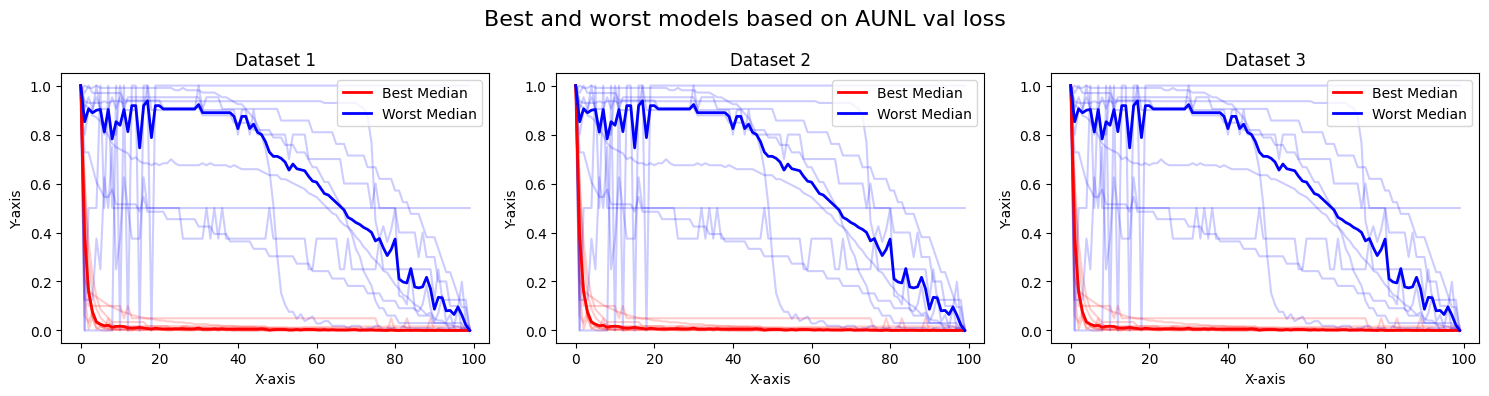

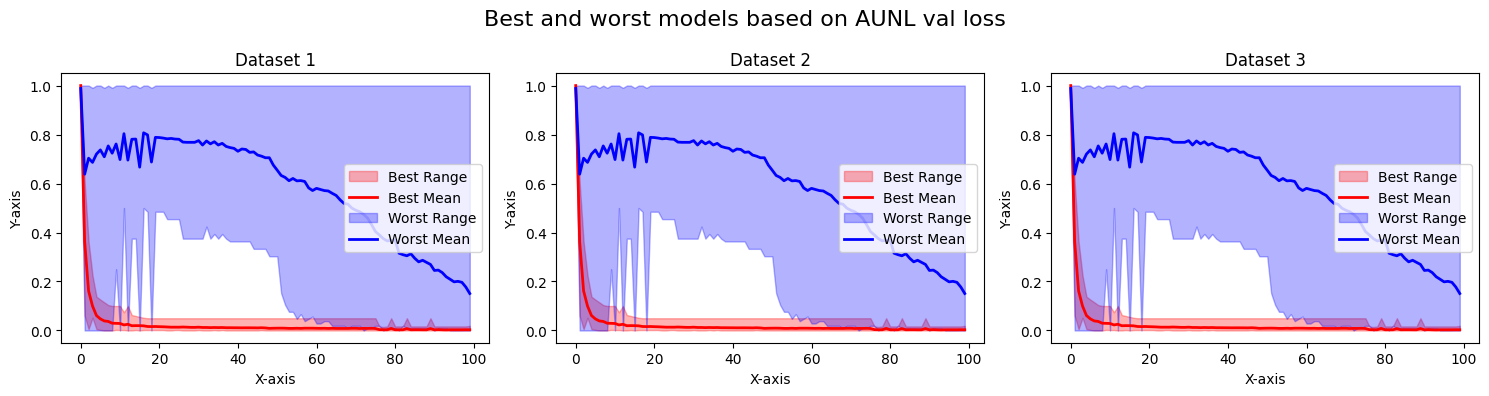

In [74]:
plot_subplots_with_all_lines(b1, w1, b1, w1, b1, w1, "Best and worst models based on AUNL val loss")
plot_subplots_with_combined_range(b1, w1, b1, w1, b1, w1, "Best and worst models based on AUNL val loss")

In [75]:
b1, w1 = get_arrays("../../output/e_e3a04821_weather.csv", "aunl", "loss", 10)
# b2, w2 = get_arrays("../../output/e_d3d21199_mm_45674.csv", "aunl", "loss", 10)
# b3, w3 = get_arrays("../../output/e_eff93bd1_mm_25624.csv", "aunl", "loss", 10)

Selected low metrics
299     0.0205
799     0.0100
2599    0.0196
2899    0.0076
3799    0.0183
4199    0.0179
4399    0.0162
6299    0.0195
6399    0.0136
6899    0.0095
Name: aunl, dtype: float64
Selected high metrics
2399    0.2052
2699    0.1992
2799    0.3110
3099    0.1552
5499    0.4205
5599    0.1380
8099    0.2511
8599    0.1501
8799    0.1561
9499    0.2813
Name: aunl, dtype: float64
Min and max
0.0076 0.4205


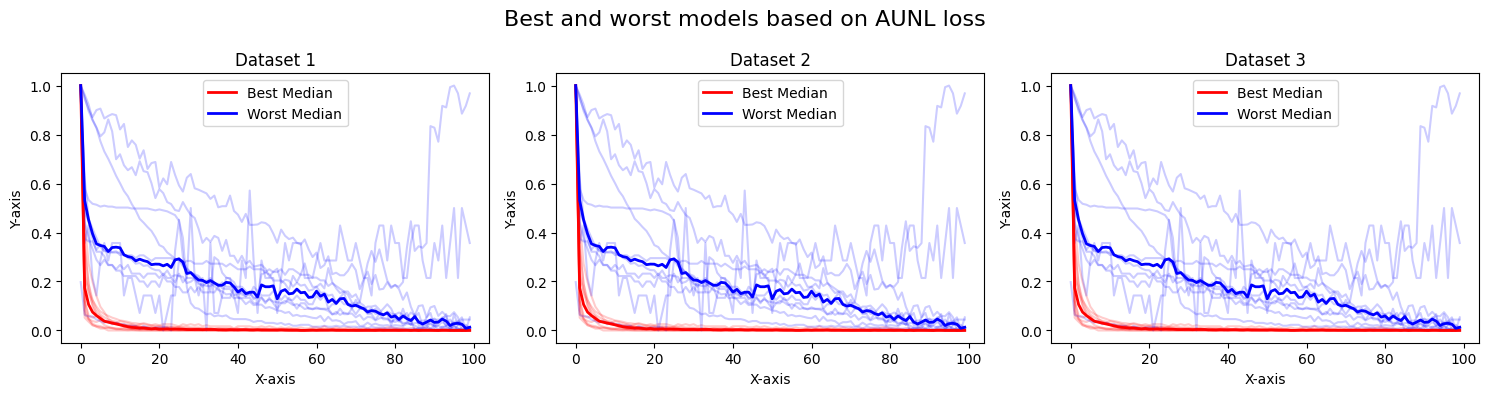

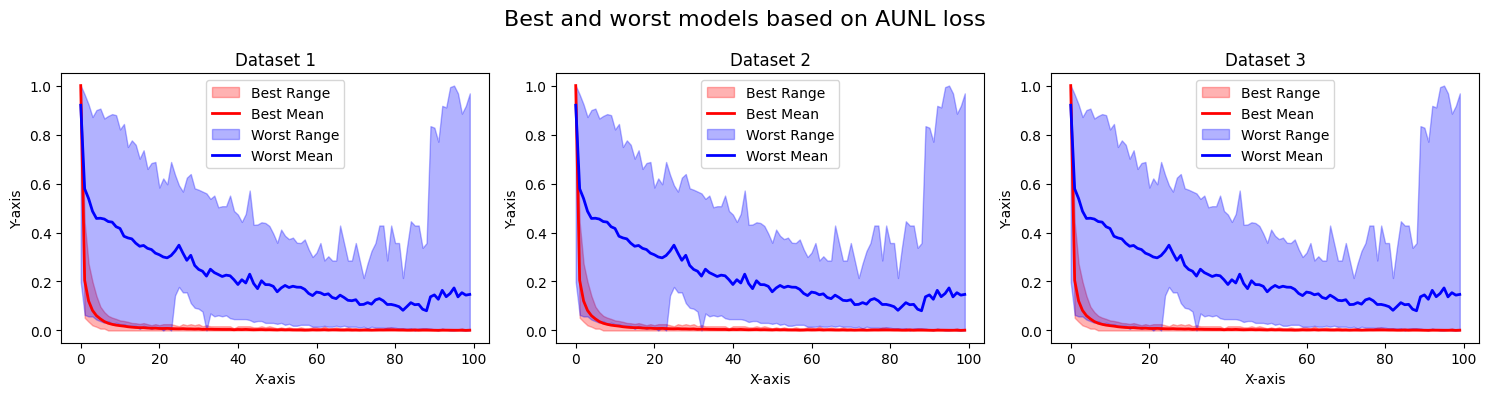

In [76]:
plot_subplots_with_all_lines(b1, w1, b1, w1, b1, w1, "Best and worst models based on AUNL loss")
plot_subplots_with_combined_range(b1, w1, b1, w1, b1, w1, "Best and worst models based on AUNL loss")


In [77]:
b1, w1 = get_arrays("../../output/e_e3a04821_weather.csv", "mae", "val_loss", 10)
# b2, w2 = get_arrays("../../output/e_d3d21199_mm_45674.csv", "mae", "val_loss", 10)
# b3, w3 = get_arrays("../../output/e_eff93bd1_mm_25624.csv", "mae", "val_loss", 10)

Selected low metrics
399     2.7382
1399    2.7885
4199    2.7588
5299    2.7893
5699    2.7856
6099    2.7725
7699    2.7653
7799    2.8015
9699    2.7879
9799    2.7490
Name: mae, dtype: float64
Selected high metrics
99       4.6273
2199     4.6253
2599     4.6195
2899     4.6191
3199     4.6270
4699    10.9072
6399     4.6190
7399     4.6179
8099     4.7545
9599     4.6191
Name: mae, dtype: float64
Min and max
2.7382 10.9072


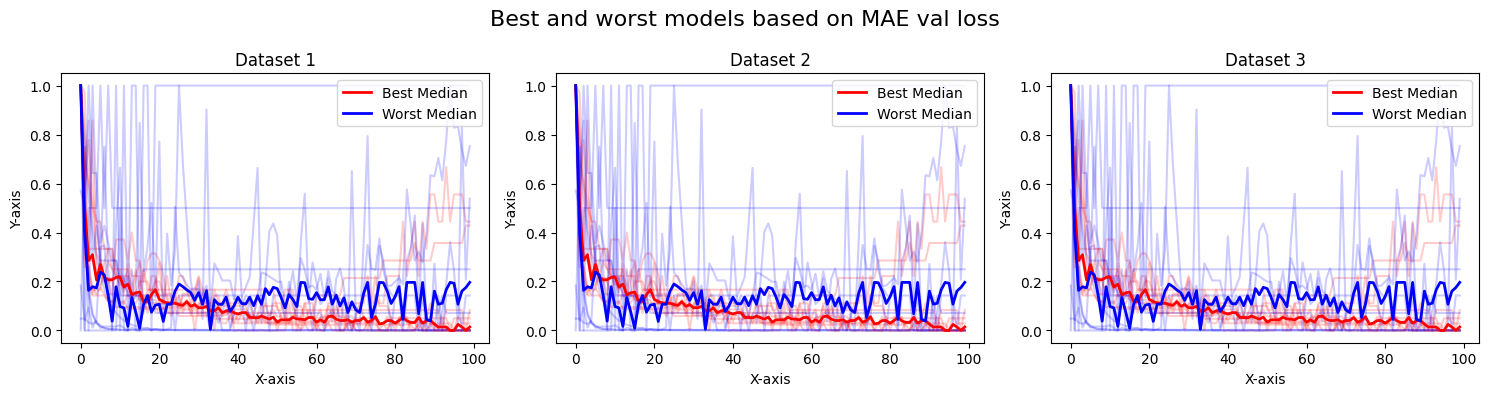

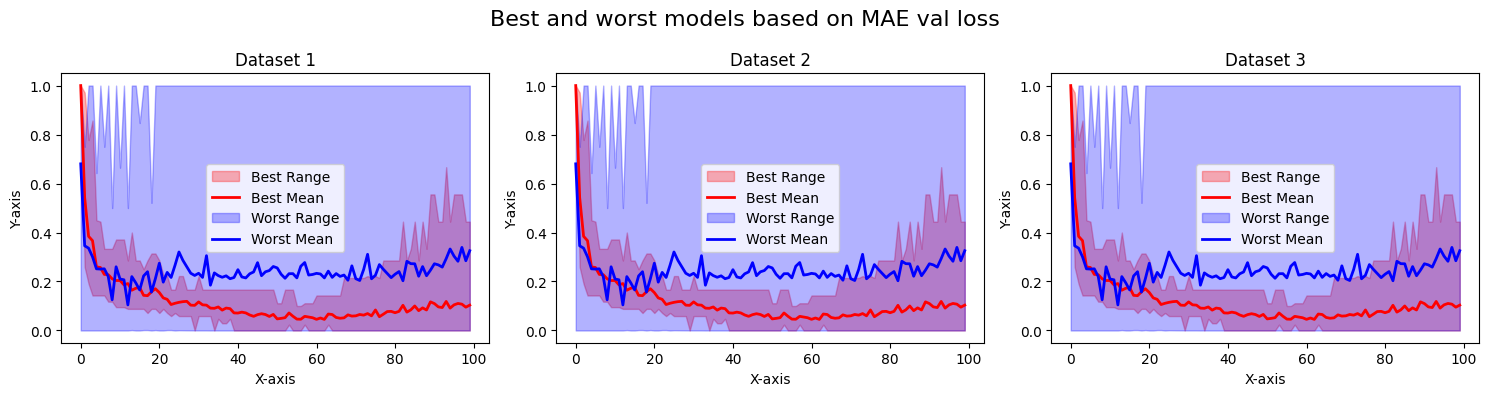

In [78]:
plot_subplots_with_all_lines(b1, w1, b1, w1, b1, w1, "Best and worst models based on MAE val loss")
plot_subplots_with_combined_range(b1, w1, b1, w1, b1, w1, "Best and worst models based on MAE val loss")

In [81]:
b1, w1 = get_arrays("../../output/e_e3a04821_weather.csv", "mae", "loss", 10)
# b2, w2 = get_arrays("../../output/e_d3d21199_mm_45674.csv", "mae", "loss", 10)
# b3, w3 = get_arrays("../../output/e_eff93bd1_mm_25624.csv", "mae", "loss", 10)

Selected low metrics
399     2.7382
1399    2.7885
4199    2.7588
5299    2.7893
5699    2.7856
6099    2.7725
7699    2.7653
7799    2.8015
9699    2.7879
9799    2.7490
Name: mae, dtype: float64
Selected high metrics
99       4.6273
2199     4.6253
2599     4.6195
2899     4.6191
3199     4.6270
4699    10.9072
6399     4.6190
7399     4.6179
8099     4.7545
9599     4.6191
Name: mae, dtype: float64
Min and max
2.7382 10.9072


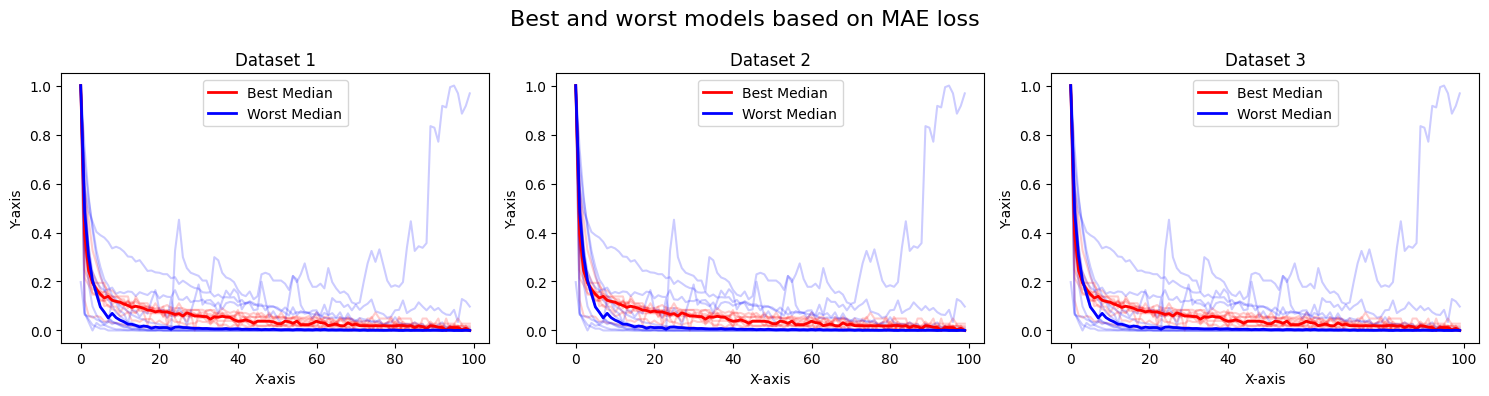

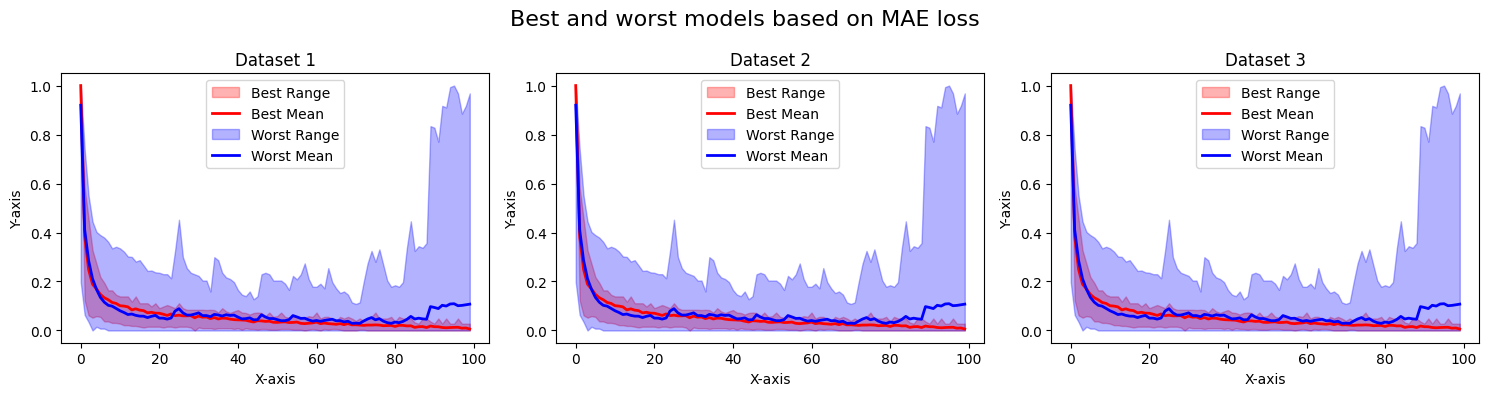

In [82]:
plot_subplots_with_all_lines(b1, w1, b1, w1, b1, w1, "Best and worst models based on MAE loss")
plot_subplots_with_combined_range(b1, w1, b1, w1, b1, w1, "Best and worst models based on MAE loss")

In [303]:
b1, w1 = get_arrays("../../output/e_40ba794e_us_births.csv", "smape", "val_loss", 10)
# b2, w2 = get_arrays("../../output/e_d3d21199_mm_45674.csv", "smape", "loss", 10)
# b3, w3 = get_arrays("../../output/e_eff93bd1_mm_25624.csv", "smape", "loss", 10)

Selected low metrics
199     0.0213
2499    0.0218
2799    0.0202
3199    0.0207
4199    0.0208
6399    0.0206
6599    0.0206
8599    0.0202
8699    0.0205
9399    0.0198
Name: smape, dtype: float64
Selected high metrics
299     0.1033
1099    0.1044
1799    0.1034
2999    0.1044
3599    0.1132
4499    0.1028
4599    0.1060
6099    0.1033
7199    0.1051
7299    0.1045
Name: smape, dtype: float64
Min and max
0.0198 0.1132


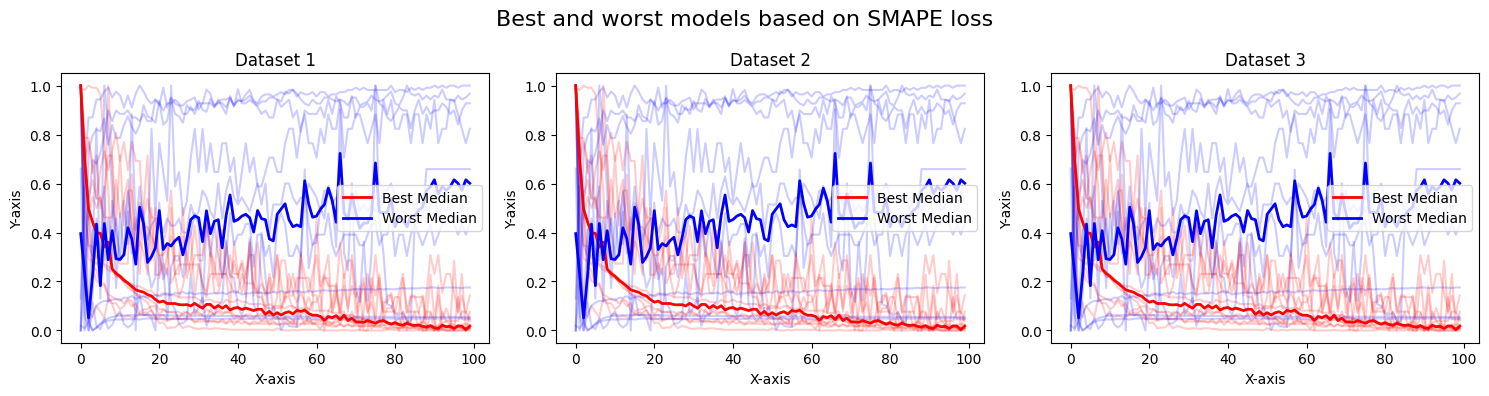

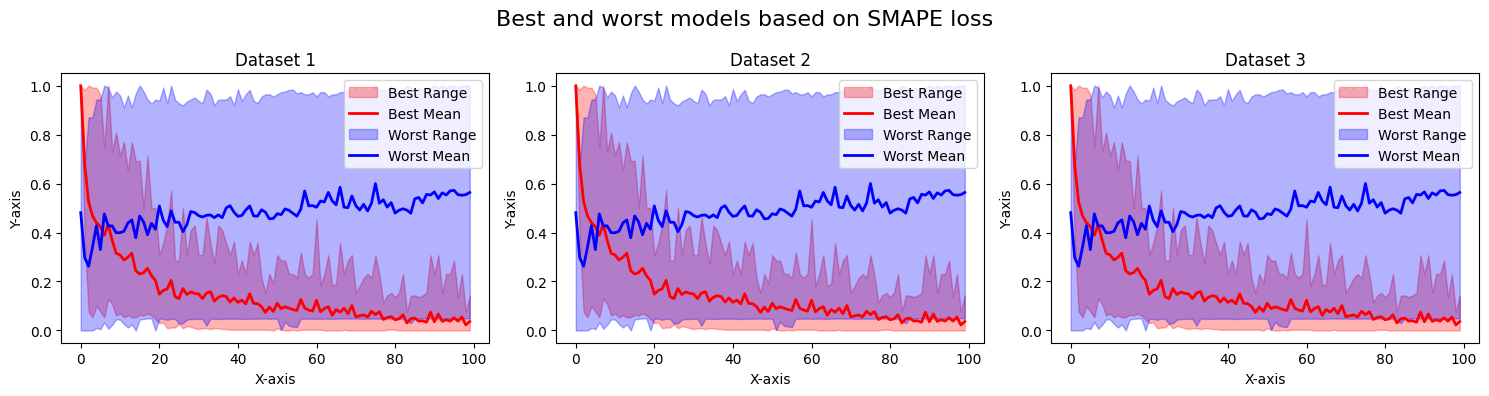

In [304]:
plot_subplots_with_all_lines(b1, w1, b1, w1, b1, w1, "Best and worst models based on SMAPE loss")
plot_subplots_with_combined_range(b1, w1, b1, w1, b1, w1, "Best and worst models based on SMAPE loss")

Columns in CSV: Index(['timestamp', 'experiment_id', 'file_path', 'loss_function',
       'num_epochs', 'hpo', 'patience', 'train_size', 'val_size', 'step_check',
       'window_size', 'optimizer_finetuning', 'is_descrete', 'has_model',
       'aunl_stopping', 'include_budget', 'budget', 'budget_strategy',
       'reference_metric', 'tolerance', 'n_trails', 'search_sampler',
       'population_size', 'generations', 'crossover_prob', 'mutation_prob',
       'elite', 'indpb', 'tournsize', 'strategy', 'popsize', 'maxiter',
       'recombination', 'mutation', 'init', 'polish', 'tol', 'atol',
       'model_id', 'num_layers', 'layers', 'neurons', 'activation',
       'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'beta_1',
       'beta_2', 'rho', 'momentum', 'centered', 'weight_decay', 'clipnorm',
       'clipvalue', 'evaluation_epoch', 'epoch', 'mae', 'mse', 'smape', 'rmse',
       'loss', 'val_loss', 'aunl', 'aunl_val', 'training_time'],
      dtype='object')
Mutual Informatio

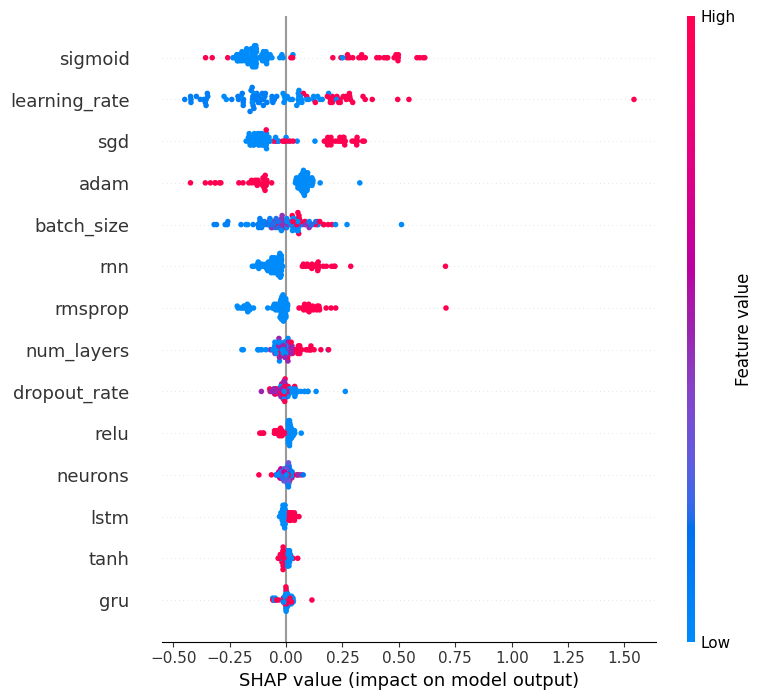

Correlation Matrix:
                     mae  batch_size   neurons  dropout_rate      lstm  \
mae            1.000000    0.212254 -0.054333      0.005289  0.163239   
batch_size     0.212254    1.000000 -0.154363      0.083772  0.019790   
neurons       -0.054333   -0.154363  1.000000     -0.187108  0.089113   
dropout_rate   0.005289    0.083772 -0.187108      1.000000  0.040716   
lstm           0.163239    0.019790  0.089113      0.040716  1.000000   
gru           -0.129515   -0.109209  0.041659     -0.008752 -0.587302   
rnn           -0.037120    0.098424 -0.143940     -0.035183 -0.454257   
sigmoid        0.329981    0.072201  0.039310      0.019244  0.085876   
relu          -0.173409   -0.179030  0.161219      0.043323 -0.037297   
tanh          -0.144885    0.103889 -0.192051     -0.059803 -0.045232   
adam          -0.377723   -0.081425 -0.061288      0.016677 -0.069084   
sgd            0.546763    0.127166 -0.080419     -0.009133  0.013299   
rmsprop       -0.187430   -0.0

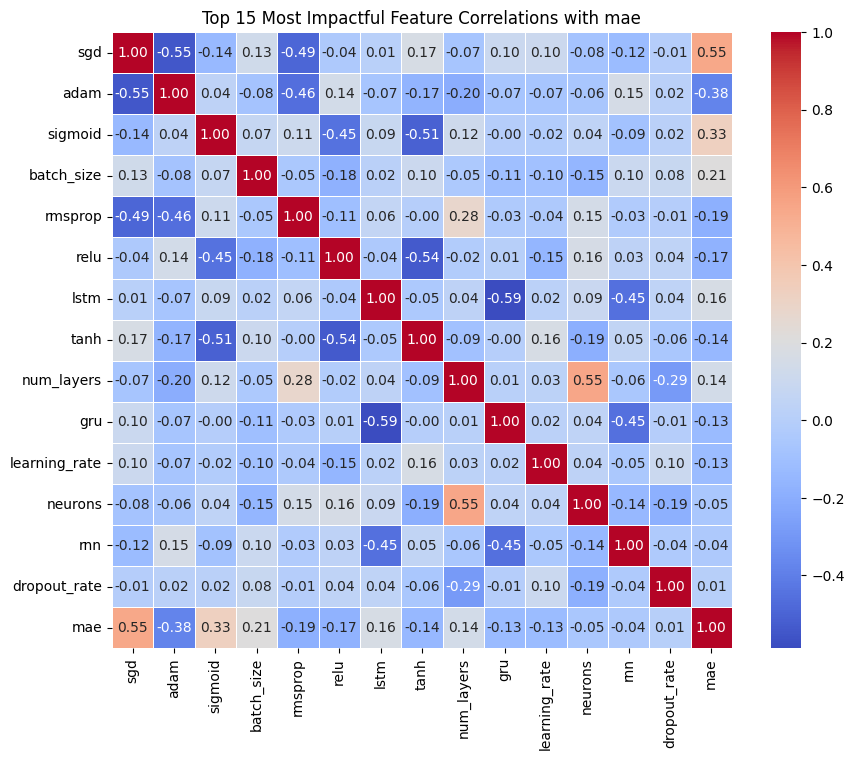

In [85]:
plot_corr("../../output/e_e3a04821_weather.csv", "mae")
# plot_corr("../../output/e_d3d21199_mm_45674.csv", "mae", "Dataset 2")
# plot_corr("../../output/e_eff93bd1_mm_25624.csv", "mae", "Dataset 3")


Columns in CSV: Index(['timestamp', 'experiment_id', 'file_path', 'loss_function',
       'num_epochs', 'hpo', 'patience', 'train_size', 'val_size', 'step_check',
       'window_size', 'optimizer_finetuning', 'is_descrete', 'has_model',
       'aunl_stopping', 'include_budget', 'budget', 'budget_strategy',
       'reference_metric', 'tolerance', 'n_trails', 'search_sampler',
       'population_size', 'generations', 'crossover_prob', 'mutation_prob',
       'elite', 'indpb', 'tournsize', 'strategy', 'popsize', 'maxiter',
       'recombination', 'mutation', 'init', 'polish', 'tol', 'atol',
       'model_id', 'num_layers', 'layers', 'neurons', 'activation',
       'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'beta_1',
       'beta_2', 'rho', 'momentum', 'centered', 'weight_decay', 'clipnorm',
       'clipvalue', 'evaluation_epoch', 'epoch', 'mae', 'mse', 'smape', 'rmse',
       'loss', 'val_loss', 'aunl', 'aunl_val', 'training_time'],
      dtype='object')
Mutual Informatio

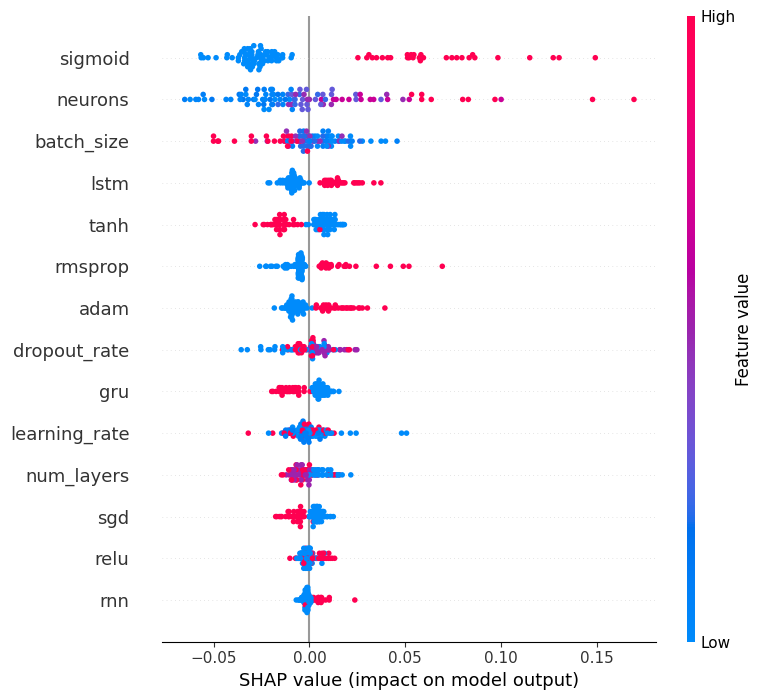

Correlation Matrix:
                aunl_val  batch_size   neurons  dropout_rate      lstm  \
aunl_val       1.000000   -0.189046  0.208752     -0.044106  0.208443   
batch_size    -0.189046    1.000000 -0.154363      0.083772  0.019790   
neurons        0.208752   -0.154363  1.000000     -0.187108  0.089113   
dropout_rate  -0.044106    0.083772 -0.187108      1.000000  0.040716   
lstm           0.208443    0.019790  0.089113      0.040716  1.000000   
gru           -0.188352   -0.109209  0.041659     -0.008752 -0.587302   
rnn           -0.022114    0.098424 -0.143940     -0.035183 -0.454257   
sigmoid        0.233594    0.072201  0.039310      0.019244  0.085876   
relu           0.086890   -0.179030  0.161219      0.043323 -0.037297   
tanh          -0.304043    0.103889 -0.192051     -0.059803 -0.045232   
adam           0.212080   -0.081425 -0.061288      0.016677 -0.069084   
sgd           -0.253648    0.127166 -0.080419     -0.009133  0.013299   
rmsprop        0.048479   -0.0

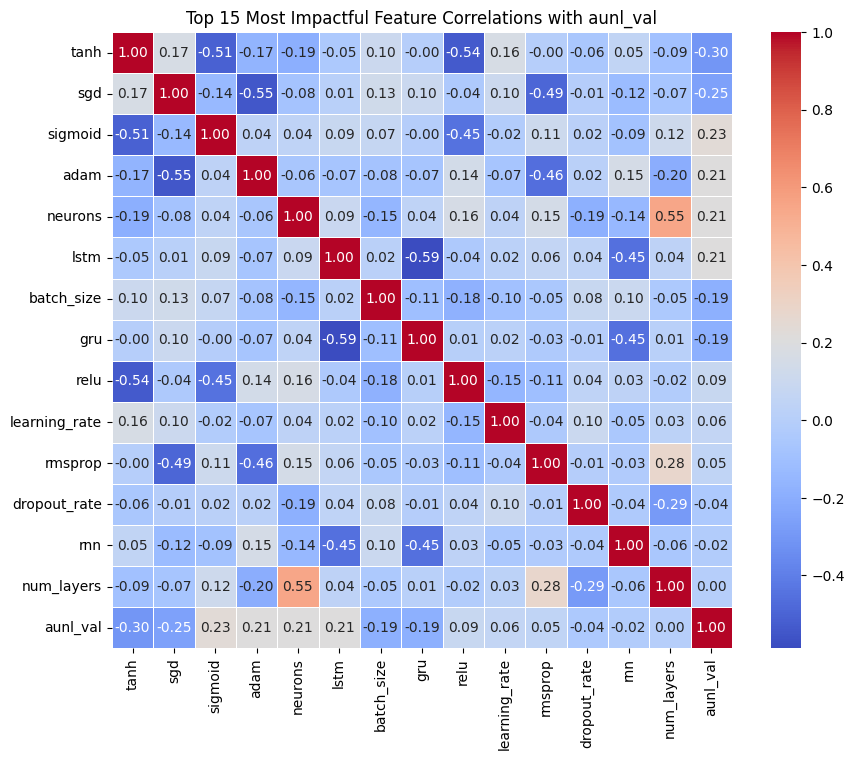

In [86]:
plot_corr("../../output/e_e3a04821_weather.csv", "aunl_val")


Columns in CSV: Index(['timestamp', 'experiment_id', 'file_path', 'loss_function',
       'num_epochs', 'hpo', 'patience', 'train_size', 'val_size', 'step_check',
       'window_size', 'optimizer_finetuning', 'is_descrete', 'has_model',
       'aunl_stopping', 'include_budget', 'budget', 'budget_strategy',
       'reference_metric', 'tolerance', 'n_trails', 'search_sampler',
       'population_size', 'generations', 'crossover_prob', 'mutation_prob',
       'elite', 'indpb', 'tournsize', 'strategy', 'popsize', 'maxiter',
       'recombination', 'mutation', 'init', 'polish', 'tol', 'atol',
       'model_id', 'num_layers', 'layers', 'neurons', 'activation',
       'dropout_rate', 'learning_rate', 'batch_size', 'optimizer', 'beta_1',
       'beta_2', 'rho', 'momentum', 'centered', 'weight_decay', 'clipnorm',
       'clipvalue', 'evaluation_epoch', 'epoch', 'mae', 'mse', 'smape', 'rmse',
       'loss', 'val_loss', 'aunl', 'aunl_val', 'training_time'],
      dtype='object')
Mutual Informatio

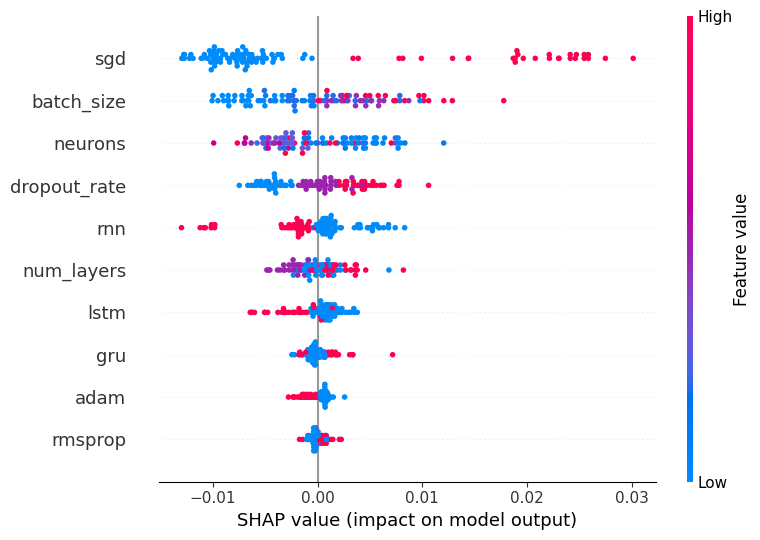

Correlation Matrix:
                  smape  batch_size   neurons  dropout_rate      lstm  \
smape         1.000000    0.216952 -0.277197      0.299930 -0.150300   
batch_size    0.216952    1.000000  0.031254     -0.052298  0.151592   
neurons      -0.277197    0.031254  1.000000     -0.105827  0.111743   
dropout_rate  0.299930   -0.052298 -0.105827      1.000000 -0.062570   
lstm         -0.150300    0.151592  0.111743     -0.062570  1.000000   
gru           0.287066   -0.017584 -0.046318      0.149938 -0.448528   
rnn          -0.122762   -0.130415 -0.064950     -0.079555 -0.549434   
sigmoid       0.118726    0.128184  0.147777     -0.061294  0.138235   
relu          0.235580   -0.069393 -0.139359      0.013916 -0.194509   
tanh         -0.352910   -0.062598 -0.013782      0.048882  0.050204   
adam         -0.338445   -0.021085 -0.066790      0.050895  0.180077   
sgd           0.508474    0.010160 -0.136251      0.287719 -0.073583   
rmsprop      -0.140735    0.012164  0.20237

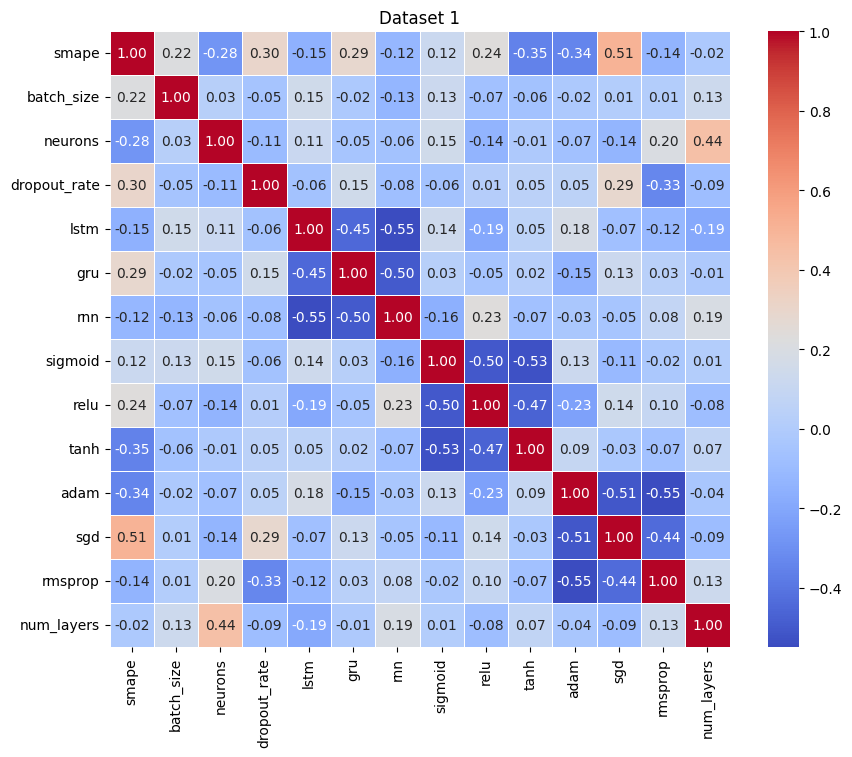

In [327]:
plot_corr("../../output/e_40ba794e_us_births.csv", "smape", "Dataset 1")

In [4]:
df1 = pd.read_csv("../../output/e_elektrika_1.csv")
df2 = pd.read_csv("../../output/e_elektrika_2.csv")
df3 = pd.read_csv("../../output/e_elektrika_3.csv")

In [13]:
df = pd.read_csv("../../output/e_weather.csv")
df = df[df["epoch"] == 99]

In [5]:
df1 = df1[df1["epoch"] == 99]
df2 = df2[df2["epoch"] == 99]
df3 = df3[df3["epoch"] == 99]

In [12]:
df[["mae", "mse", "rmse", "smape"]].describe()

,mae,mse,rmse,smape
count,100.000000,100.000000,100.000000,100.000000
mean,3.444186,20.701059,4.427523,0.174600
std,0.985308,13.763518,1.053180,0.073002
min,2.738200,13.459200,3.668700,0.134700
25%,2.874150,14.300550,3.781575,0.141600
50%,3.133550,16.238200,4.029650,0.155400
75%,3.589525,21.038025,4.586650,0.181525
max,10.907200,136.681100,11.691100,0.815100


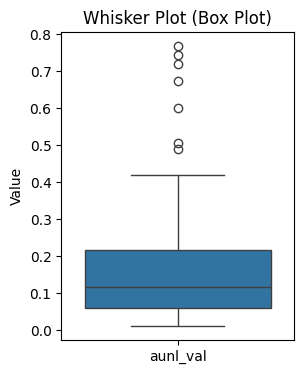

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(3, 4))  # Width = 12 inches, Height = 6 inches

# Create the box plot (whisker plot)
sns.boxplot(df[["aunl_val"]])

# Add labels and title
plt.ylabel('Value')
plt.title('Whisker Plot (Box Plot)')

# Show the plot
plt.show()

In [7]:
df2[["mae", "mse", "rmse", "smape"]].describe()

,mae,mse,rmse,smape
count,100.000000,100.000000,100.000000,100.000000
mean,0.858658,1.075240,1.036830,0.379924
std,0.017702,0.032338,0.015518,0.006349
min,0.819600,1.012500,1.006300,0.365300
25%,0.844050,1.050325,1.024875,0.375100
50%,0.857550,1.075000,1.036850,0.379150
75%,0.871450,1.096150,1.047000,0.384250
max,0.913200,1.195600,1.093400,0.398400


In [8]:
df3[["mae", "mse", "rmse", "smape"]].describe()

,mae,mse,rmse,smape
count,100.000000,100.000000,100.000000,100.000000
mean,2.296944,7.810908,2.794683,0.252484
std,0.051067,0.145440,0.025831,0.005188
min,2.183100,7.511600,2.740700,0.240600
25%,2.259375,7.723950,2.779200,0.248700
50%,2.288800,7.781750,2.789600,0.251750
75%,2.324050,7.873875,2.806050,0.255375
max,2.489300,8.483100,2.912600,0.271500


In [45]:
def catch_22(path, column, normalize, target_metric):
    df = pd.read_csv(path)

    # Group by model_id and extract loss curves
    grouped = df.groupby("model_id")[column].apply(list)

    # Extract Catch22 features for each model
    feature_dict = {}
    for model_id, loss in grouped.items():
        loss_array = np.array(loss)
        if normalize:
            loss_array = normalize_array(loss_array)  # Normalize if required
        
        # Compute Catch22 features
        catch22_features = catch22.catch22_all(loss_array)["values"]
        
        # Convert list to dictionary with feature names
        feature_dict_values = dict(zip(catch22.catch22_all(np.zeros(100))["names"], catch22_features))
        
        # Extract the target metric
        target_metric_value = df.loc[df['model_id'] == model_id, target_metric].iloc[99]

        # Add target metric to the dictionary
        feature_dict_values["target_metric"] = target_metric_value

        # Store features in a dictionary
        feature_dict[model_id] = feature_dict_values

    # Convert dictionary to DataFrame
    features_df = pd.DataFrame.from_dict(feature_dict, orient="index")

    # Reset index to keep model_id as a column
    features_df = features_df.reset_index().rename(columns={"index": "model_id"})

    return features_df


In [ ]:
def get_features_per_dataset(path, column, target_metric_column):
    # Read the dataset
    df = pd.read_csv(path)

    # Group by model_id and extract loss curves
    grouped = df.groupby("model_id")[column].apply(list)

    features_dict = {}

    # Loop over each model and extract features
    for model_id, loss in grouped.items():
        loss_array = normalize_array( np.array(loss))
        # Extract features
        final_df = pd.DataFrame({column: loss_array, "id": 0, "epoch": range(len(loss))})
        features_dict[model_id] = extract_features(final_df, column_id="id", column_sort="epoch")
        
        target_metric = df.loc[df['model_id'] == model_id, target_metric_column].iloc[99]
        features_dict[model_id]["target_metric"] = target_metric

    # Convert dictionary of DataFrames into a single DataFrame
    features_df = pd.concat(features_dict, names=["model_id"]).reset_index(level=0)

    # Remove NaN and constant columns
    features_df = features_df.dropna(axis=1).loc[:, features_df.nunique() > 2]

    return features_df

In [ ]:
import pandas as pd
import numpy as np
import src.notebooks.utils as utils  

def get_calculations_per_dataset(path, column, normalize, target):
    df = pd.read_csv(path)

    # Group by model_id and extract loss curves
    grouped = df.groupby("model_id")[column].apply(list)

    # Extract features for each model
    features_list = []
    
    for model_id, loss in grouped.items():
        # Convert loss to NumPy array
        loss_array = np.array(loss, dtype=np.float64)

        # Normalize if required
        if normalize:
            loss_array = (loss_array - np.min(loss_array)) / (np.max(loss_array) - np.min(loss_array) + 1e-8)

        # Compute all feature sets
        stats_features = utils.calculate_statistics(loss_array)
        spectral_features = utils.calculate_spectral_features(loss_array)
        advanced_freq_features = utils.calculate_advanced_frequency_features(loss_array)
        freq_features = utils.calculate_frequency_domain_features(loss_array)
        time_features = utils.calculate_time_domain_features(loss_array)

        # Combine all features into a single dictionary
        features = {
            "model_id": model_id,
            "target": df.loc[df['model_id'] == model_id, target].iloc[99],
            **stats_features,
            **spectral_features,
            **advanced_freq_features,
            **freq_features,
            **time_features
        }

        # Append results to list
        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Remove NaN and constant columns
    features_df = features_df.dropna(axis=1).loc[:, features_df.nunique() > 2]

    return features_df


In [24]:
tsfresh_n = get_features_per_dataset("../../output/e_e3a04821_weather.csv", "val_loss", "mae")

Feature Extraction: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


In [29]:
tsfresh_n = tsfresh_n.drop(columns=["model_id"])

KeyError: "['model_id'] not found in axis"

In [30]:
tsfresh_n.columns

Index(['val_loss__sum_values', 'val_loss__abs_energy',
       'val_loss__mean_abs_change', 'val_loss__mean_change',
       'val_loss__mean_second_derivative_central', 'val_loss__median',
       'val_loss__mean', 'val_loss__standard_deviation',
       'val_loss__variation_coefficient', 'val_loss__variance',
       ...
       'val_loss__fourier_entropy__bins_5',
       'val_loss__fourier_entropy__bins_10',
       'val_loss__fourier_entropy__bins_100',
       'val_loss__permutation_entropy__dimension_3__tau_1',
       'val_loss__permutation_entropy__dimension_4__tau_1',
       'val_loss__permutation_entropy__dimension_5__tau_1',
       'val_loss__permutation_entropy__dimension_6__tau_1',
       'val_loss__permutation_entropy__dimension_7__tau_1',
       'val_loss__mean_n_absolute_max__number_of_maxima_7', 'target_metric'],
      dtype='object', length=515)

In [31]:
tsfresh_n.columns = range(tsfresh_n.shape[1])

In [42]:
tsfresh_n[514].min()

2.7382

Mutual Information Scores:
 21     0.423351
26     0.370902
69     0.360378
80     0.332803
35     0.319018
409    0.317935
174    0.295102
302    0.294789
13     0.294319
312    0.288499
2      0.287820
185    0.286313
406    0.283766
388    0.280475
90     0.278560
dtype: float64


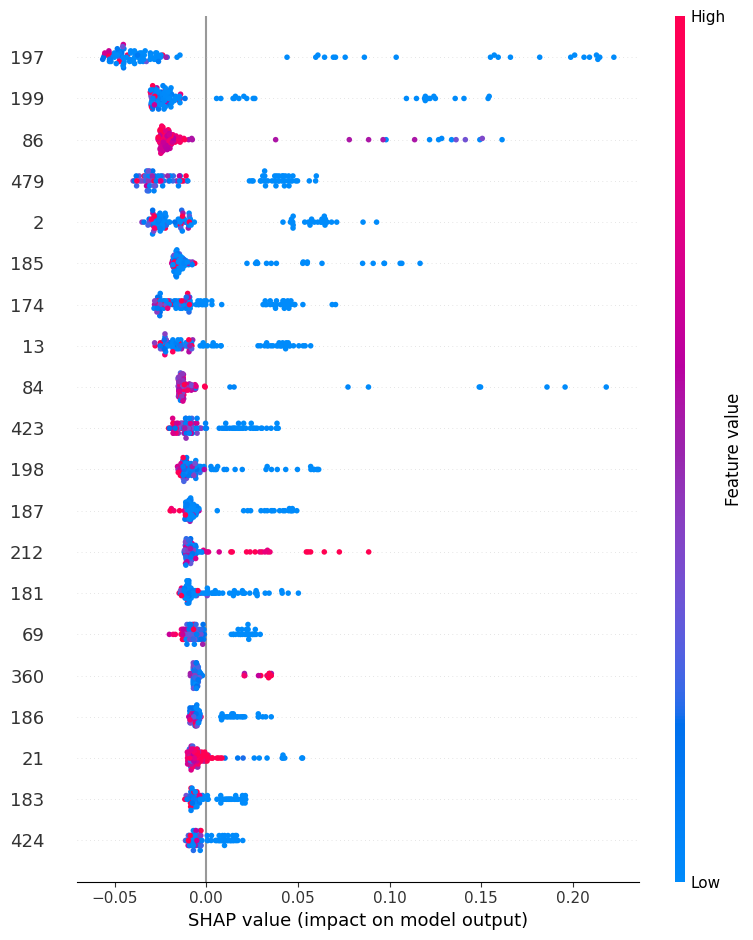

In [40]:
analyze_data(tsfresh_n, 514)

In [55]:
catch = catch_22("../../output/e_e3a04821_weather.csv", "val_loss", False, "aunl_val")
catch_n = catch_22("../../output/e_e3a04821_weather.csv", "val_loss", True, "aunl_val")

col_n = catch_n.columns.to_list()
col  = catch.columns.to_list()

In [56]:
catch_n = catch_n.drop(columns=["model_id"])
catch = catch.drop(columns=["model_id"])

catch_n.columns = range(catch_n.shape[1])
catch.columns = range(catch.shape[1])

Mutual Information Scores:
 1     1.058803
0     1.021869
13    0.740011
4     0.660299
2     0.565707
21    0.482840
20    0.456518
7     0.449199
15    0.402785
14    0.332028
6     0.287104
18    0.176793
5     0.175590
3     0.138819
17    0.131343
dtype: float64


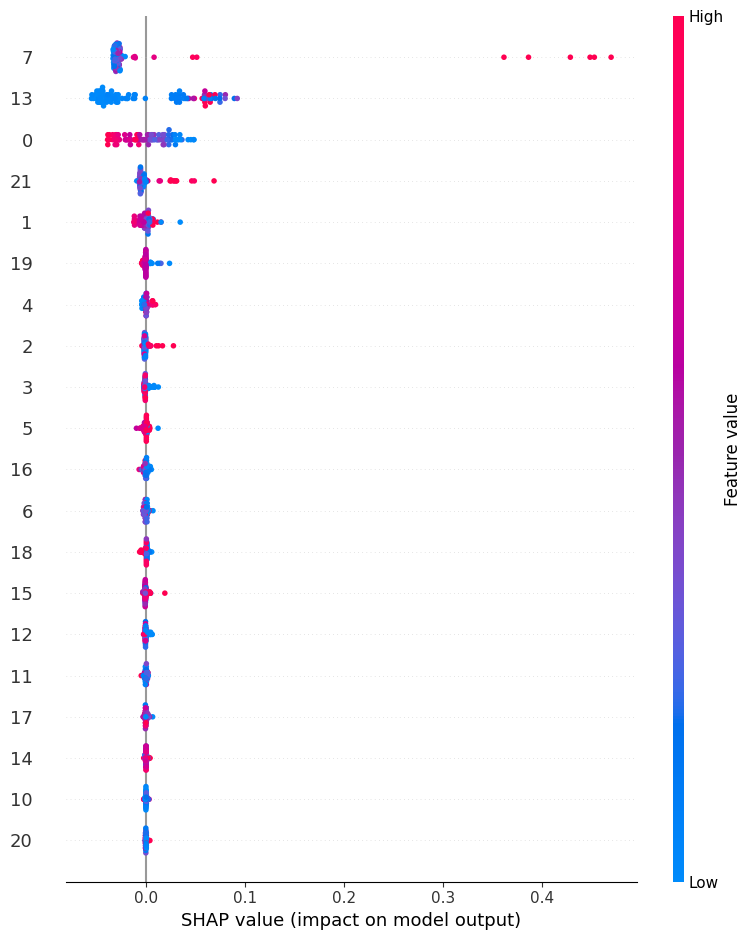

Correlation Matrix:
           0         1         2         3         4         5         6   \
0   1.000000  0.784194 -0.411077  0.087555 -0.459520 -0.436736 -0.465131   
1   0.784194  1.000000 -0.350927 -0.046936 -0.360689 -0.322484 -0.314073   
2  -0.411077 -0.350927  1.000000  0.423226  0.946427  0.604416  0.195905   
3   0.087555 -0.046936  0.423226  1.000000  0.412803  0.261584 -0.387617   
4  -0.459520 -0.360689  0.946427  0.412803  1.000000  0.694506  0.269135   
5  -0.436736 -0.322484  0.604416  0.261584  0.694506  1.000000  0.258432   
6  -0.465131 -0.314073  0.195905 -0.387617  0.269135  0.258432  1.000000   
7  -0.114845 -0.066963  0.659162  0.337577  0.587560  0.233640 -0.065070   
8   0.095853 -0.053371  0.015079  0.075293 -0.016474 -0.052746 -0.327969   
9  -0.200986 -0.008870 -0.233033 -0.583374 -0.182606 -0.149376  0.382629   
10 -0.406865 -0.340030  0.751743  0.445904  0.808295  0.793519  0.274033   
11 -0.152101 -0.215405  0.530843  0.663863  0.526483  0.424062 -0.1

KeyError: 512

In [57]:
analyze_data(catch_n, catch, 22)

In [72]:
hmade = get_calculations_per_dataset("../../output/e_e3a04821_weather.csv", "val_loss", False, "mae")
hmade_n = get_calculations_per_dataset("../../output/e_e3a04821_weather.csv", "val_loss", True, "mae")

In [73]:
hmade_n = hmade_n.drop(columns=["model_id"])
hmade = hmade.drop(columns=["model_id"])

In [74]:
hmade_n.columns = range(hmade_n.shape[1])
hmade.columns = range(hmade.shape[1])

Mutual Information Scores:
 1     1.070840
7     0.833140
2     0.347068
5     0.346233
36    0.346214
38    0.331573
21    0.295972
39    0.283161
35    0.266577
37    0.253814
11    0.250201
6     0.227527
3     0.206704
13    0.185242
9     0.184386
dtype: float64


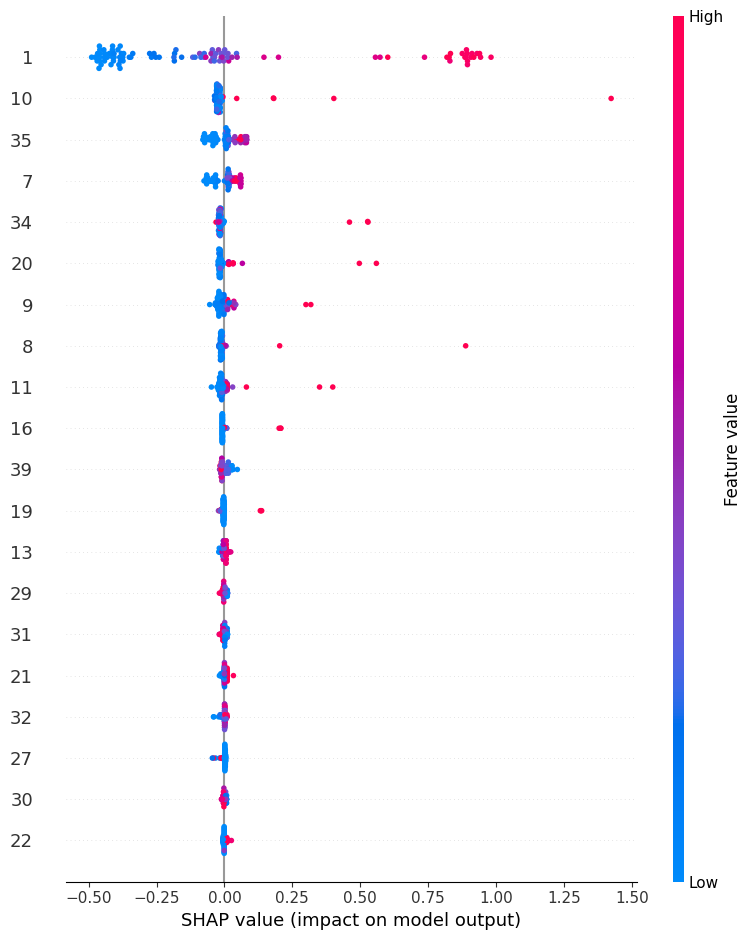

Correlation Matrix:
           0         1         2         3         4         5         6   \
0   1.000000  0.077234  0.276802  0.000882  0.000882  0.276802  0.276802   
1   0.077234  1.000000 -0.498593  0.677636  0.677636 -0.498593 -0.498593   
2   0.276802 -0.498593  1.000000 -0.102369 -0.102369  1.000000  1.000000   
3   0.000882  0.677636 -0.102369  1.000000  1.000000 -0.102369 -0.102369   
4   0.000882  0.677636 -0.102369  1.000000  1.000000 -0.102369 -0.102369   
5   0.276802 -0.498593  1.000000 -0.102369 -0.102369  1.000000  1.000000   
6   0.276802 -0.498593  1.000000 -0.102369 -0.102369  1.000000  1.000000   
7   0.102923  0.949883 -0.378767  0.834155  0.834155 -0.378767 -0.378767   
8  -0.267610  0.394827 -0.664376  0.003084  0.003084 -0.664376 -0.664376   
9  -0.113418 -0.027711 -0.504534 -0.510603 -0.510603 -0.504534 -0.504534   
10 -0.290629  0.469079 -0.745129  0.011569  0.011569 -0.745129 -0.745129   
11 -0.235087  0.239664 -0.675418 -0.279940 -0.279940 -0.675418 -0.6

KeyError: 512

In [75]:
analyze_data(hmade_n, hmade, 0)

In [27]:
for i, d in enumerate(tsfresh_n.columns.to_list()):
    print(f"{i}: {d}")

0: val_loss__sum_values
1: val_loss__abs_energy
2: val_loss__mean_abs_change
3: val_loss__mean_change
4: val_loss__mean_second_derivative_central
5: val_loss__median
6: val_loss__mean
7: val_loss__standard_deviation
8: val_loss__variation_coefficient
9: val_loss__variance
10: val_loss__skewness
11: val_loss__kurtosis
12: val_loss__root_mean_square
13: val_loss__absolute_sum_of_changes
14: val_loss__longest_strike_below_mean
15: val_loss__longest_strike_above_mean
16: val_loss__count_above_mean
17: val_loss__count_below_mean
18: val_loss__last_location_of_maximum
19: val_loss__first_location_of_maximum
20: val_loss__last_location_of_minimum
21: val_loss__first_location_of_minimum
22: val_loss__percentage_of_reoccurring_values_to_all_values
23: val_loss__percentage_of_reoccurring_datapoints_to_all_datapoints
24: val_loss__sum_of_reoccurring_values
25: val_loss__sum_of_reoccurring_data_points
26: val_loss__ratio_value_number_to_time_series_length
27: val_loss__sample_entropy
28: val_loss_

In [57]:
import pandas as pd

df = pd.read_csv("../../output/e_sh.csv")

len(df['model_id'].unique())

100

In [58]:
def get_df(df):
    # Filter the data to include only rows where 'evaluation_epoch' is True
    filtered_data = df[df["evaluation_epoch"] == True]

    # Get unique model_ids
    ids = df['model_id'].unique()

    # Initialize an empty list to store the results
    arr = []

    # Loop through each model_id
    for id in ids:
        # Filter the data for the current model_id and get the row with the maximum epoch
        model_data = filtered_data[filtered_data['model_id'] == id]
        max_epoch_row = model_data.loc[model_data['epoch'].idxmax()]  # Get the row with the max epoch

        # Append the result to the list
        arr.append(max_epoch_row)

    # If you want to create a DataFrame from the results
    return pd.DataFrame(arr)


In [59]:
# Count how many instances have unique epochs in result_df
result_df = get_df(df)
result_df['epoch'].value_counts()

epoch
9     55
19    21
39    11
99    10
79     3
Name: count, dtype: int64

In [7]:
result_df[['mae', 'mse', 'smape', 'rmse']].astype(float).describe().round(4)

,mae,mse,smape,rmse
count,100.0000,100.0000,100.0000,100.0000
mean,17.8699,1010.6223,0.4929,25.0634
std,20.3991,3640.8277,0.2415,19.6549
min,7.9613,240.9523,0.2265,15.5226
25%,10.5181,308.2204,0.3404,17.5560
50%,15.4756,536.0310,0.4902,23.1523
75%,17.6665,606.1911,0.5402,24.6209
max,186.2998,35288.8693,2.0000,187.8533


In [9]:
import os

def list_files_in_directory(directory):
    # Get a list of all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files


In [10]:
# Example usage
directory_path = '../../output/'  # Replace with your folder path
files = list_files_in_directory(directory_path)

In [11]:
def get_time(data):
    data["timestamp"] = pd.to_datetime(data["timestamp"], errors='coerce')

    # Get the first and last row for that timestamp
    first_time = data["timestamp"].iloc[0]
    last_time = data["timestamp"].iloc[-1]

    # Calculate the time difference
    time_difference = last_time - first_time
    time_difference_str = str(time_difference)
    time = time_difference_str.split()[2] if len(time_difference_str.split()) > 2 else "00:00:00"
    return time

In [12]:
def get_netric(df, metric):
    # Filter the data to include only rows where 'evaluation_epoch' is True
    filtered_data = df[df["evaluation_epoch"] == True]

    # Get unique model_ids
    ids = df['model_id'].unique()

    # Initialize an empty list to store the results
    arr = []

    # Loop through each model_id
    for id in ids:
        # Filter the data for the current model_id and get the row with the maximum epoch
        model_data = filtered_data[filtered_data['model_id'] == id]
        max_epoch_row = model_data.loc[model_data['epoch'].idxmax()]  # Get the row with the max epoch

        # Append the result to the list
        arr.append(max_epoch_row)

    # If you want to create a DataFrame from the results
    result_df = pd.DataFrame(arr)
    return result_df[[metric]].min().to_numpy()[0]


In [69]:
labels = ['SH-dynamic', 'SH WS-dynamic', 'SH-fixed', 'SH WS-fixed']
files = ['e_sh.csv', 'e_ws_sh_var_nm.csv', 'e_nws_sh_fix_m.csv', 'e_ws_sh_fix_m.csv']

In [70]:
times = []
maes = []
for file in files:
    df = pd.read_csv(f'../../output/{file}')
    times.append(get_time(df))
    maes.append(get_netric(df, 'mae'))

maes

[8.8774, 8.7991, 10.653, 10.5143]

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def time_to_seconds(time_str):
    """
    Convert time in "hh:mm:ss" format to seconds.
    
    Args:
    - time_str: A string representing the time in "hh:mm:ss" format.
    
    Returns:
    - int: The total number of seconds represented by the time.
    """
    t = datetime.strptime(time_str, "%H:%M:%S")
    return t.hour * 3600 + t.minute * 60 + t.second

def plot_time_bar_chart(times, labels):
    """
    Creates a bar plot from an array of time values in "hh:mm:ss" format with custom labels for the x-axis.
    
    Args:
    - times: A list of time strings in "hh:mm:ss" format.
    - labels: A list of labels for the x-axis.
    """
    # Convert the time strings to seconds
    time_in_seconds = [time_to_seconds(t) for t in times]
    
    # Create an array of positions for the bars
    x_pos = np.arange(len(time_in_seconds))
    
    # Create the bar plot
    plt.bar(x_pos, time_in_seconds, align='center', alpha=0.7)
    
    # Set the x-tick labels to the provided labels
    plt.xticks(x_pos, labels, rotation=45, ha='right')
    
    # Set labels and title
    plt.xlabel('Categories')
    plt.ylabel('Time (seconds)')
    plt.title('Bar plot of training time')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bar_chart(data, labels):
    """
    Creates a bar plot from an array of time values in "hh:mm:ss" format with custom labels for the x-axis.
    
    Args:
    - data: A list or array of numeric values to plot.
    - labels: A list of labels for the x-axis.
    """
    # Create an array of positions for the bars
    x_pos = np.arange(len(data))
    
    # Create the bar plot
    bars = plt.bar(x_pos, data, align='center', alpha=0.7)
    
    # Set the x-tick labels to the provided labels
    plt.xticks(x_pos, labels, rotation=45, ha='right')
    
    # Add values on top of the bars
    for bar in bars:
        yval = bar.get_height()  # Get the height of the bar
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01,  # Position the text slightly above the bar
                 round(yval, 2),  # Display the value (rounded to 2 decimal places)
                 ha='center', va='bottom', fontsize=10)  # Align and format the text

    # Set labels and title
    plt.xlabel('Categories')
    plt.ylabel('MAE')
    plt.title('Bar plot of MAE')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


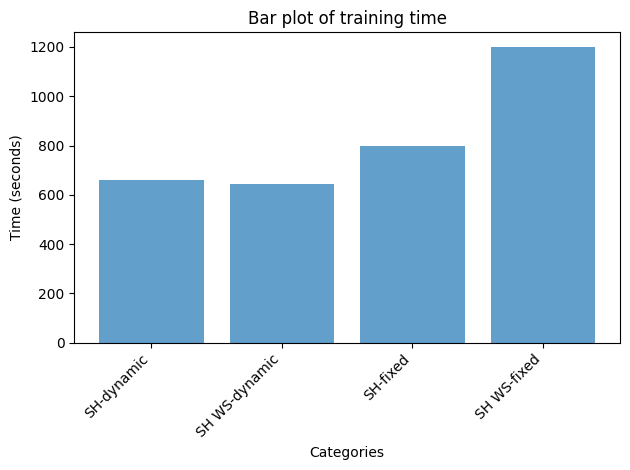

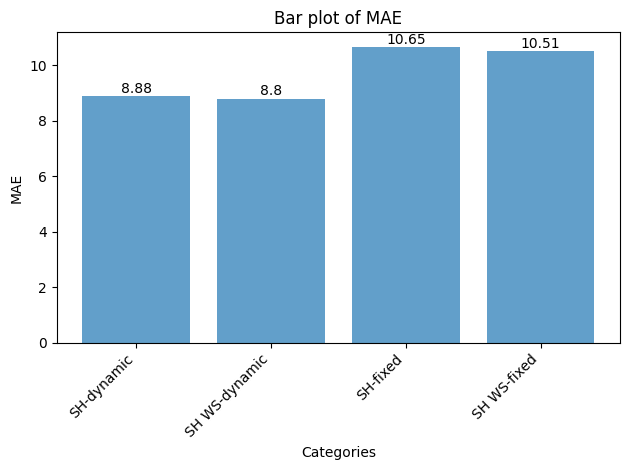

In [73]:
# Example usage
plot_time_bar_chart(times, labels)
plot_bar_chart(maes, labels)

In [46]:
import pandas as pd
df = pd.read_csv("../../output/e_default_sh.csv")

len(df['model_id'].unique())

100

In [66]:
df = pd.read_csv('../../output/e_global_sh.csv')
result_df = get_df(df)

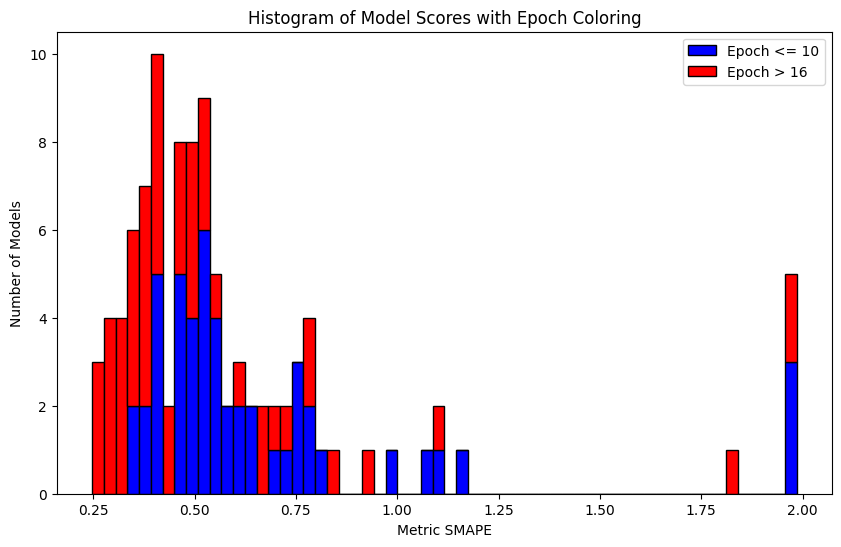

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
metric_scores = result_df['smape']  # Adjust to your actual metric column (e.g., 'mae')
epochs = result_df['epoch']  # Adjust to your actual epoch column

# Define the minimum and maximum values for your metric
min_value = min(metric_scores)
max_value = max(metric_scores)

# Define the number of bins you want
num_bins = 60

# Create bins that fit tightly around your data range
bins = np.linspace(min_value, max_value, num_bins+1)

# Initialize lists to store counts of models in each bin for red and blue categories
blue_counts = np.zeros(len(bins)-1)
red_counts = np.zeros(len(bins)-1)

# Loop through each score and classify it based on epoch value
for score, epoch in zip(metric_scores, epochs):
    # Find the appropriate bin for the current score
    bin_idx = np.digitize(score, bins) - 1  # bins are inclusive on the left, exclusive on the right
    
    # Make sure bin_idx is within valid range
    bin_idx = min(bin_idx, len(bins)-2)

    # Separate into blue and red based on epoch
    if epoch <= 10:
        blue_counts[bin_idx] += 1
    else:
        red_counts[bin_idx] += 1

# Plot the stacked bar plot
plt.figure(figsize=(10,6))
plt.bar(bins[:-1], blue_counts, width=np.diff(bins), color='blue', edgecolor='black', label="Epoch <= 10")
plt.bar(bins[:-1], red_counts, width=np.diff(bins), bottom=blue_counts, color='red', edgecolor='black', label="Epoch > 16")

# Adding labels and title
plt.xlabel("Metric SMAPE")
plt.ylabel("Number of Models")
plt.title("Histogram of Model Scores with Epoch Coloring")

# Add legend
plt.legend()

# Show the plot
plt.show()


In [623]:
df = pd.read_csv('../../output/e_63783a62_mm_25624.csv')
len(df['model_id'].unique())



180

In [624]:
nan_counts = df.isna().sum()

In [625]:
nan_counts

timestamp         0
experiment_id     0
file_path         0
loss_function     0
num_epochs        0
                 ..
loss             20
val_loss         20
aunl             18
aunl_val         18
training_time     0
Length: 68, dtype: int64

In [621]:
def get_last_epoch(df) -> pd.DataFrame:
    """
    Get the last epoch for each unique model_id where evaluation_epoch is True.
    
    Args:
        df (pd.DataFrame): The input DataFrame with 'model_id', 'epoch', and 'evaluation_epoch'.
    
    Returns:
        pd.DataFrame: A DataFrame containing the rows with the highest epoch for each model_id.
    """
    ids = df["model_id"].unique()  # Only get unique model_ids from filtered data
    arr = []
    
    for model_id in ids:
        model_data = filtered_data[filtered_data['model_id'] == model_id]

        if model_data.empty:
            print(f"[WARNING] No evaluation data found for model_id {model_id}")
            continue  # Skip empty model_data

        max_epoch_row = model_data.loc[model_data['epoch'].idxmax()]  # Safe now
        arr.append(max_epoch_row)

    if not arr:
        print("[WARNING] No valid model epochs found. Returning empty DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame if no data found

    return pd.DataFrame(arr)  # Convert list of rows back to DataFrame

In [622]:
len(get_last_epoch(df)['model_id'].unique())

180